# Plots for the Poster

## Comparing Average Precisions Across Models

In [2]:
iou = 0.5
inFile = '../../5_evaluate/output/mAP.txt'

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import json

# Load Data
data = []
with open(inFile) as f:
    for line in f:
        j_content = json.loads(line)
        data.append(j_content)


In [4]:
# extract relevent data
data_iou = [x for x in data if x['iouThresh']==iou]

noaug = [(x['mAP'], x['banana treeAP'], x['coconut treeAP']) for x in data_iou if x['model']=='noaugment30000']
noaug = list(itertools.chain(*noaug)) # Flattens List
print(noaug)

basic = [(x['mAP'], x['banana treeAP'], x['coconut treeAP']) for x in data_iou if x['model']=='basic30000']
basic = list(itertools.chain(*basic)) # Flattens Lis
print(basic)

frz22 = [(x['mAP'], x['banana treeAP'], x['coconut treeAP']) for x in data_iou if x['model']=='22froze30000']
frz22 = list(itertools.chain(*frz22)) # Flattens List
print(frz22)

frz13 = [(x['mAP'], x['banana treeAP'], x['coconut treeAP']) for x in data_iou if x['model']=='13froze30000']
frz13 = list(itertools.chain(*frz13)) # Flattens List
print(frz13)



[0.567202587838466, 0.4105952633603984, 0.7238099123165336]
[0.5248029573146751, 0.3448189224163954, 0.7047869922129548]
[0.0006857956993943266, 0.00023019253577348175, 0.0011413988630151715]
[0.4675887782621057, 0.2599237839688532, 0.6752537725553582]


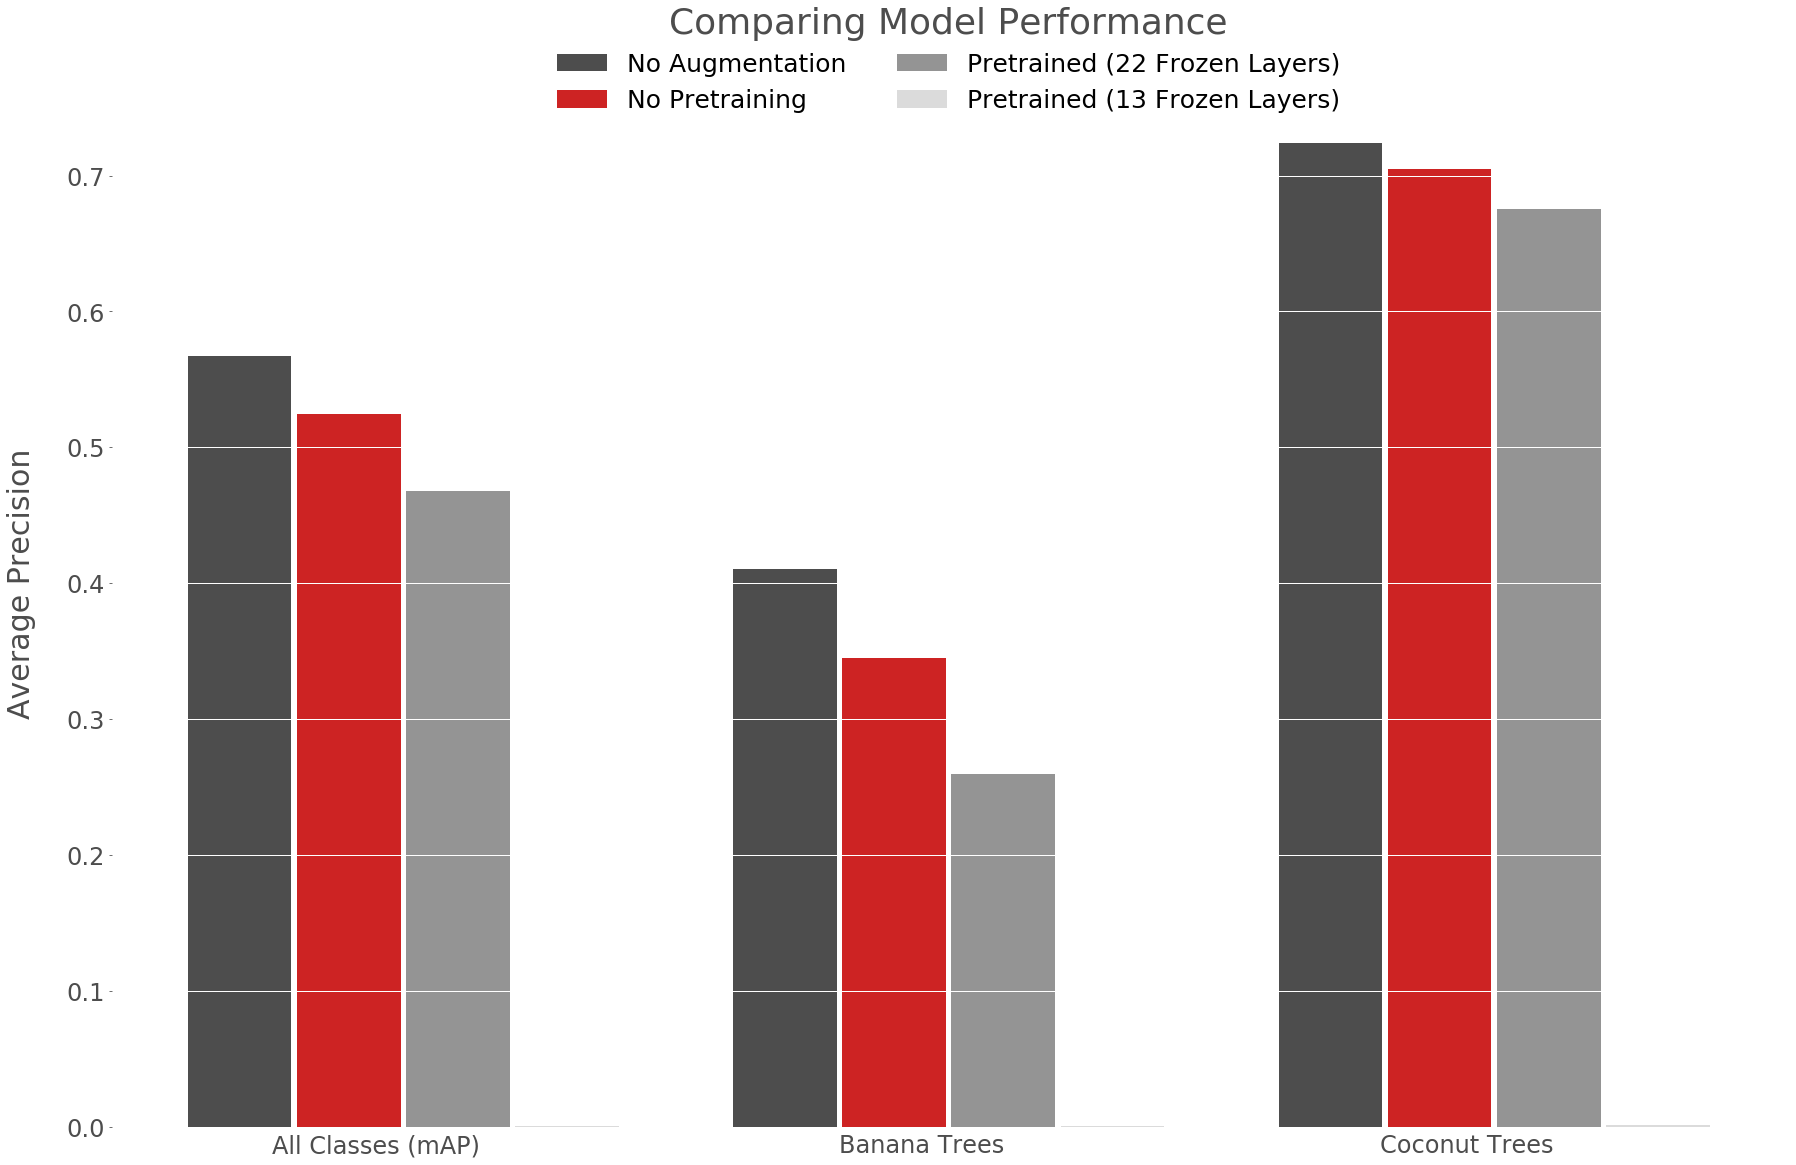

In [7]:
# Plot
fig, ax = plt.subplots(ncols=1, figsize=(30,20))

ind = np.arange(len(basic))
width = 0.19
colours = ['#4d4d4d', '#cd2323', '#4d4d4d', '#4d4d4d']

p1 = ax.bar(ind, noaug, width, color=colours[0], alpha=1)
p2 = ax.bar(ind+width+0.01, basic, width, color=colours[1], alpha=1)
p3 = ax.bar(ind+2*(width+0.01), frz13, width, color=colours[3], alpha=0.6)
p4 = ax.bar(ind+3*(width+0.01), frz22, width, color=colours[2], alpha=0.2)

# Adjust spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Adjust Ticks
ax.tick_params(axis='y', direction='out', color='#4d4d4d', which='both', labelcolor='#4d4d4d', labelsize=24)
ax.tick_params(axis='x', color='white', labelcolor='#4d4d4d', labelsize=24)
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
plt.xticks([0.25, 1.25, 2.25], ['All Classes (mAP)', 'Banana Trees', 'Coconut Trees'])

# Adjust Grid
ax.grid(axis='y', color='white', linewidth=1)
ax.set_ylim(0, 0.8)

# Add text to plot
ax.set_ylabel('Average Precision', color='#4d4d4d', size=30, labelpad=30)

# Add Legend
ax.legend((p1[0], p2[0], p3[0], p4[0]), 
          ('No Augmentation', 'No Pretraining',
          'Pretrained (22 Frozen Layers)', "Pretrained (13 Frozen Layers)"),
          loc=9, ncol=2, frameon=False, borderpad=0, prop={'size': 25})


# Add Title
ax.set_title('Comparing Model Performance', size=36, color='#4d4d4d')
plt.savefig('../output/plot.png')

##  Plotting Ground Truth & Predictions


In [9]:
# This code plots ground truth and prediction bounding boxes for the images specified in the tiles_of_interest variable

# path to tiled images
img_path = '../../3_tileAnnotate/output/'

# path to weights file
predDir = '../../5_evaluate/input/results/basic30000/'
conThresh = 0.2 # Confidence threshold to accept a prediction
tiles_of_interest = ['tile.22.18', 'tile.5.5', 'tile.40.16', 'tile.41.9', 'tile.22.18']

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import pandas as pd
import numpy as np
import os

def train2mplRect(ratios, imagew, imageh):
    xratio, yratio, wratio, hratio = ratios
    
    left = xratio*imagew - wratio/2*imagew
    top = yratio*imageh - hratio/2*imageh

    width = wratio * imagew
    height = hratio * imageh
    
    return (left, top), width, height

for tile in tiles_of_interest:
    im = np.array(Image.open(img_path + tile + '.jpeg'), dtype=np.uint8)
    imageh, imagew, dim = im.shape

    # Ground Truth Data
    gt = pd.read_csv(img_path + tile + '.txt', 
                     delimiter=' ', header=None)
    gt.columns=['class', 'xratio', 'yratio', 'wratio', 'hratio']
    gt['temp'] = list(zip(gt['xratio'], gt['yratio'], gt['wratio'], gt['hratio']))
    gt['gtRect'] = gt['temp'].apply(train2mplRect, args=(imagew, imageh))

    # Predictions
    predFiles = os.listdir(predDir)

    # *********
    # Plotting
    # *********
    colormap = {0: 'gold', 1: 'gainsboro'}
    classmap = {'banana tree': 0, 'coconut tree': 1}

    # Create figure and axes
    fig,ax = plt.subplots(1, figsize=(imagew/50,imageh/50))

    # Display the image
    ax.imshow(im)

    # Draw all the ground truth boxes
    for c, g in zip(gt['class'], gt['gtRect']):
        try: 
            color = colormap[c]
            rect = patches.Rectangle(*g,linewidth=1,edgecolor=color,facecolor='none', 
                                     linestyle='solid', lw=3)
            ax.add_patch(rect)
        except Exception as e:
            pass

    for p in predFiles:
        predictions = pd.read_csv(predDir + p, delimiter=' ', header=None)
        predictions.columns = ['filename', 'confidence', 'xmin', 'ymin', 'xmax', 'ymax']
        predictions = predictions[predictions['filename'] == tile + '.jpg']
        predictions = predictions[predictions['confidence'] > conThresh]
        predictions['topleft'] = list(zip(predictions.xmin, predictions.ymin))
        predictions['prRect'] = list(zip(predictions.topleft, 
                                         predictions.xmax - predictions.xmin, 
                                         predictions.ymax - predictions.ymin))
        base_name = predDir.split('/')[-2]
        class_name = p[len(base_name):-len('.txt')]
        clss = classmap[class_name]

        for r in predictions['prRect']:
            try:
                color = colormap[clss]
                rect = patches.Rectangle(*r,linewidth=1,edgecolor=color,facecolor='none', 
                                         linestyle='dashed', lw=3)
                ax.add_patch(rect)
            except Exception as e:
                print(e)
                
    # Adjust the look of the plot
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='x', bottom='off', labelbottom='off')
    ax.tick_params(axis='y', left='off', labelleft='off')

    plt.savefig('../output/Poster' + tile + '.png')

FileNotFoundError: [Errno 2] No such file or directory: '../../3_tileAnnotate/output/DarknetData/tile.22.18.jpeg'